The goal here is to compute the similarities between each descriptions and the associated skill.

In [1]:
import sys
sys.path.append("../skillExtract/")
import pandas as pd
import pickle
import seaborn as sns
from transformers import (AutoModel, AutoTokenizer)
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
tqdm.pandas()
%load_ext autoreload
%autoreload 2


tech_test = pd.read_csv("https://raw.githubusercontent.com/jensjorisdecorte/Skill-Extraction-benchmark/main/tech_test_annotations.csv")


emb_sh = "_jbEn"
with open(f"../../data/taxonomy/taxonomy_embeddings{emb_sh}.pkl", "rb") as f:
    emb_tax = pickle.load(f)

In [2]:
emb_tax["name"] = emb_tax["name+definition"].apply(lambda x : x.split(":")[0][:-1])
tax_names = set(emb_tax["name"].values)

In [3]:
print("Total tech spans : ", len(set(tech_test.span)))
print("Number of tech spans not in the taxonomy ", len(set(tech_test.span) - tax_names))

Total tech spans :  747
Number of tech spans not in the taxonomy  726


In [4]:
print("Total tech spans : ", len(set(tech_test.label)))
print("Number of tech spans not in the taxonomy ", len(set(tech_test.label) - tax_names))

Total tech spans :  274
Number of tech spans not in the taxonomy  2


In [5]:
set(tech_test.label) - tax_names

{'LABEL NOT PRESENT', 'UNDERSPECIFIED'}

So we already have the labels' embeddings, we need to compute the JobBERT embeddings of the descriptions.

In [6]:
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tech_test["embeddings"] = tech_test["sentence"]\
    .progress_apply(lambda st : \
                    word_emb_model(**word_emb_tokenizer(st, return_tensors="pt", max_length=768, padding=True, truncation=True))\
                    .last_hidden_state[:, 0, :]\
                    )

  0%|          | 0/1164 [00:00<?, ?it/s]

In [8]:
tech_test["embeddings"] = tech_test["embeddings"].apply(lambda x : x.detach())

In [9]:
known_label_set = set(emb_tax["name"].values)
def compute_cos_sim(entry):
    sentence_embedding = entry["embeddings"].detach().numpy()
    label = entry["label"]
    if(label in known_label_set):
        label_embedding = emb_tax[emb_tax["name"] == label]["embeddings"].values[0].detach().numpy()
        return cosine_similarity(sentence_embedding, label_embedding)[0][0]


tech_test["sim"] = tech_test[["embeddings", "label"]].progress_apply(compute_cos_sim, axis=1)

  0%|          | 0/1164 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of (sentence, skill) pair')

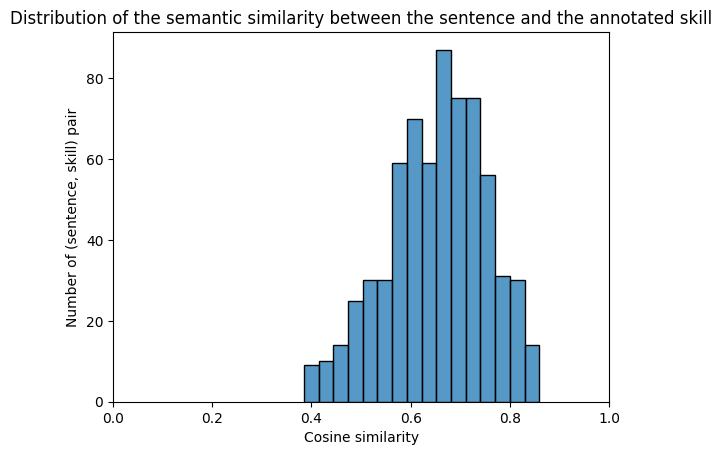

In [10]:
g = sns.histplot(data=tech_test, x="sim")
g.set_xlim((0, 1))
g.set_title("Distribution of the semantic similarity between the sentence and the annotated skill")
g.set_xlabel("Cosine similarity")
g.set_ylabel("Number of (sentence, skill) pair")

Let's look at some qualitative examples :

In [21]:
def display_top_rows(df, k):
    for i, (_, (sentence, label, sim)) in enumerate(df.head(k).iterrows()):
        print(i + 1, ") sentence : ", sentence)
        print("\t> label : ", label)
        print("\t> sim", sim)
        


print("BOTTOM FIVE EXAMPLES :")
display_top_rows(tech_test.sort_values("sim")[["sentence", "label", "sim"]], 5)
print("TOP FIVE EXAMPLES :")
display_top_rows(tech_test.sort_values("sim", ascending=False)[["sentence", "label", "sim"]], 5)


BOTTOM FIVE EXAMPLES :
1 ) sentence :  agile architecture
	> label :  software architecture models
	> sim 0.38462191820144653
2 ) sentence :  agile architecture
	> label :  software architecture models
	> sim 0.38462191820144653
3 ) sentence :  Industry: Cloud Services Information Technology Technology Consulting
	> label :  provide technical expertise
	> sim 0.39169931411743164
4 ) sentence :  Senior Java Software Engineer ( VP ) As a member of our <ORGANIZATION> <ORGANIZATION> <ORGANIZATION> we look first and foremost for people who are passionate around solving business problems through innovation & engineering practices .
	> label :  innovation processes
	> sim 0.3989642262458801
5 ) sentence :  As an experienced member of our Software Engineering Group we look first and foremost for people who are passionate around solving business problems through innovation & engineering practices .
	> label :  innovation processes
	> sim 0.4017237424850464
TOP FIVE EXAMPLES :
1 ) sentence :  Ex

## Compute the cross similarities between skills

In [7]:
skills_names = list(emb_tax["name"].values)
skills_embeddings = torch.cat(list(emb_tax["embeddings"].values)).numpy()

cross_skill_sim = cosine_similarity(skills_embeddings, skills_embeddings)

Example for skill "PostgreSQL"

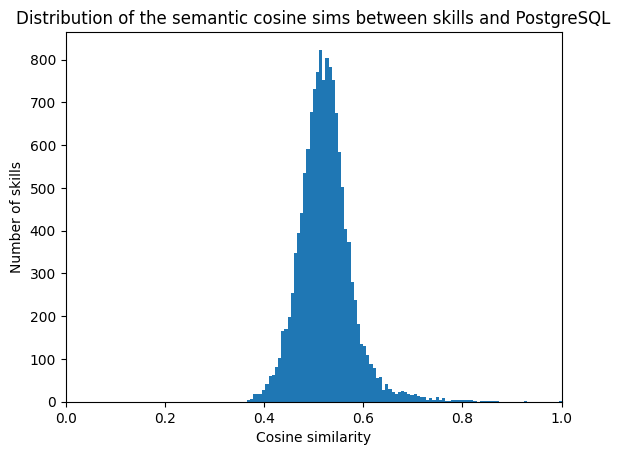

In [98]:
psql_idx = skills_names.index("PostgreSQL")

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and PostgreSQL")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

Example with 'manage musical staff'

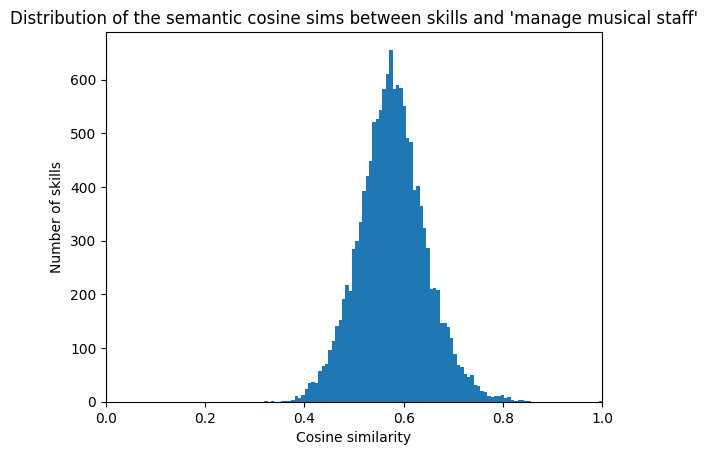

In [9]:
psql_idx = skills_names.index("manage musical staff")

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and 'manage musical staff'")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

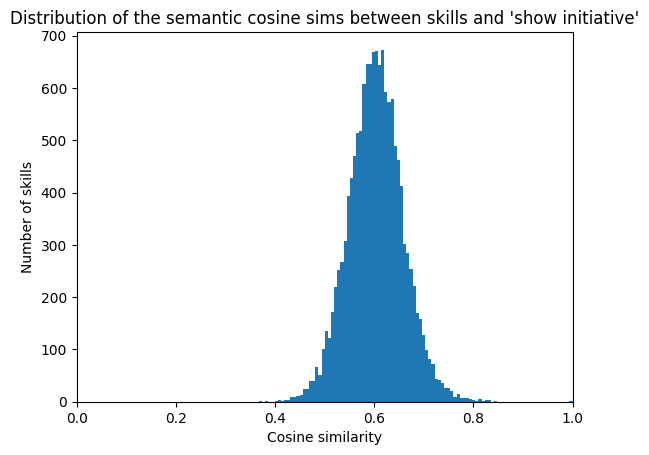

In [10]:
psql_idx = skills_names.index('show initiative')

psql_sims = cross_skill_sim[psql_idx]


f, a = plt.subplots()
plt.hist(psql_sims, bins=100);
a.set_title("Distribution of the semantic cosine sims between skills and 'show initiative'")
a.set_xlabel("Cosine similarity")
a.set_ylabel("Number of skills")
a.set_xlim((0, 1));

In [127]:
def get_kNN(label, k, cross_sims=cross_skill_sim, flipped=True):
    label_idx = skills_names.index(label)
    kNN = cross_sims[label_idx].argsort()[::-1 if flipped else 1][1:k+1] 
    kNN_labels = []
    for nn in kNN:
        kNN_labels.append(skills_names[nn])
    return kNN_labels


In [104]:
examples = ["PostgreSQL", 'show initiative', 'manage musical staff']
for ex in examples:
    print("> ", ex)
    nns = get_kNN(ex, 5)
    for i, nn in enumerate(nns):
        print("\t", i + 1, ")", nn)

>  PostgreSQL
	 1 ) MySQL
	 2 ) SQL Server
	 3 ) Oracle Relational Database
	 4 ) NoSQL
	 5 ) database management systems
>  show initiative
	 1 ) assertiveness
	 2 ) act reliably
	 3 ) moderate a debate
	 4 ) show determination
	 5 ) assess others
>  manage musical staff
	 1 ) prepare rehearsals
	 2 ) conduct military music services
	 3 ) represent artistic production
	 4 ) complete final musical scores
	 5 ) identify requirements of the work


Simply computing the number of skills per sentence in the annotated dataset :

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


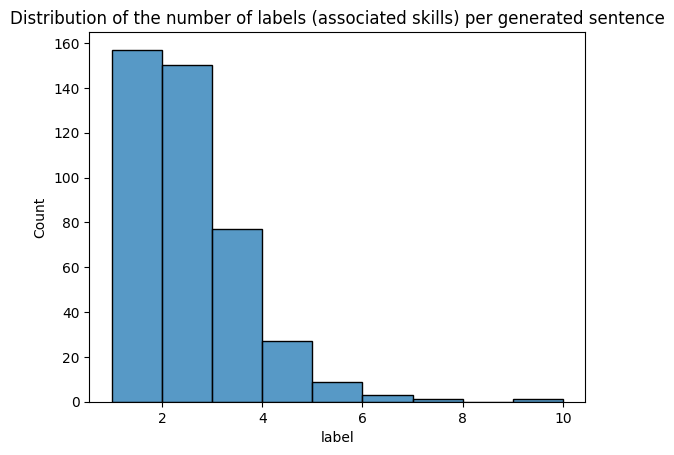

In [13]:
g = sns.histplot(
    data=tech_test[["sentence", "label"]]\
        .drop_duplicates()\
        .groupby("sentence")\
        .count()\
        .reset_index(),
    x="label",
    binwidth=1
)

g.set_title("Distribution of the number of labels (associated skills) per generated sentence");

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


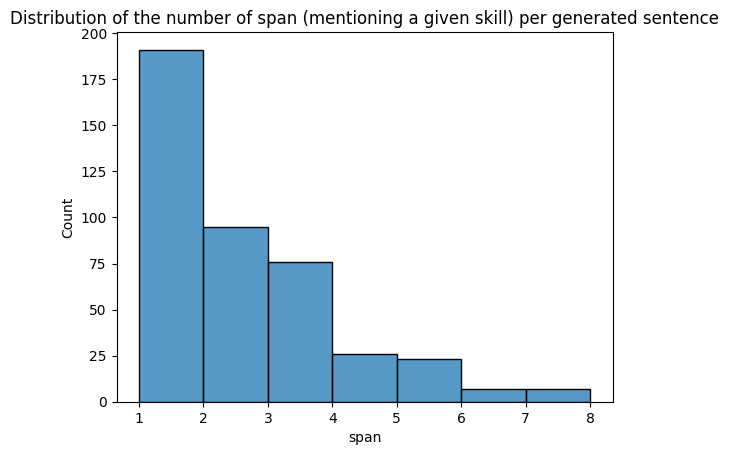

In [14]:
g = sns.histplot(
    data=tech_test[["sentence", "span"]]\
        .drop_duplicates()\
        .groupby("sentence")\
        .count()\
        .reset_index(),
    x="span",
    binwidth=1
)

g.set_title("Distribution of the number of span (mentioning a given skill) per generated sentence");

### Intra document similarities

In [37]:
unk_label = ["LABEL NOT PRESENT", "UNDERSPECIFIED"]
multilabel = tech_test[~tech_test.label.isin(unk_label)][["sentence", "label"]]\
    .groupby("sentence")\
    .agg({"label": lambda x : x.tolist()})\
    .reset_index()
multilabel["all_embeddings"] = multilabel["label"].progress_apply(
    lambda names : \
        torch.cat([emb_tax[emb_tax.name == name]["embeddings"].iloc[0] for name in names]).detach().numpy()
)

  0%|          | 0/338 [00:00<?, ?it/s]

In [72]:
def intra_doc_cross_cos_sim(all_embeddings):
    all_cross = cosine_similarity(all_embeddings, all_embeddings)
    N, M = all_cross.shape
    no_redudancy = (np.tri(N, M, -1) * all_cross).flatten()
    return no_redudancy[no_redudancy != 0]

multilabel["intra_doc_sim"] = multilabel["all_embeddings"].apply(intra_doc_cross_cos_sim)

In [82]:
ne_multilabel = multilabel[multilabel.intra_doc_sim.apply(len).astype(bool)]

/tmp/ipykernel_25992/418556702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ne_multilabel["mean_intra_doc_sim"] = ne_multilabel["intra_doc_sim"].apply(lambda x : x.mean())
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operatin

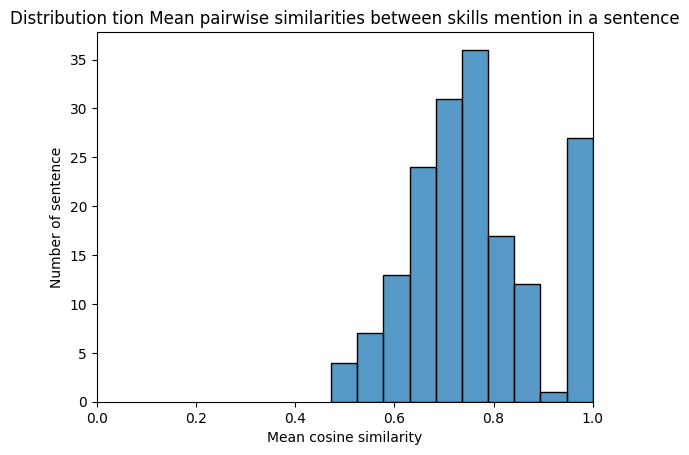

In [92]:
ne_multilabel["mean_intra_doc_sim"] = ne_multilabel["intra_doc_sim"].apply(lambda x : x.mean())
g = sns.histplot(data=ne_multilabel, x="mean_intra_doc_sim")
g.set_title("Distribution tion Mean pairwise similarities between skills mention in a sentence")
g.set_xlabel("Mean cosine similarity")
g.set_ylabel("Number of sentence")
g.set_xlim((0, 1));

====> last peak is due to multiple redundancies in the label for a given sentence

In [96]:
print(len(tech_test.index))
print(len(tech_test[["sentence", "label"]].drop_duplicates().index))


1164
876


In [115]:
all_sims = ne_multilabel["mean_intra_doc_sim"].explode()


all_sims = all_sims[all_sims != 1]
mu = str(round(all_sims.mean(), 2))
sig = str(round(all_sims.std(), 2))
display(Markdown("${X}$ if the distribution of the mean intra doc similarity"))
display(Markdown("$\mathbb{E}(X) \sim \mathcal{N}(" +  mu +", (" + sig + ")^2)$"))

${X}$ if the distribution of the mean intra doc similarity

$\mathbb{E}(X) \sim \mathcal{N}(0.75, (0.12)^2)$

We restart the qualitative example we've seen before but extracting skills of similarity centered in $0.75$.

In [118]:
mu

'0.75'

We take, for each skills the 5 skills centered in $\mu = 0.75$ to try to reproduce the distribution we have for annotated dataset.

Taking the frequency might still be very important because "IBM WebSphere" is very obscure whereas "PostgreSQL" is very popular.

In [129]:
examples = ["PostgreSQL", 'show initiative', 'manage musical staff']
for ex in examples:
    print("> ", ex)
    cross_sims = np.abs(cross_skill_sim - float(mu))
    nns = get_kNN(ex, 5, cross_sims, flipped=False)
    for i, nn in enumerate(nns):
        print("\t", i + 1, ")", nn)

>  PostgreSQL
	 1 ) IBM WebSphere
	 2 ) MDX
	 3 ) LDAP
	 4 ) Microsoft Visual C++
	 5 ) penetration testing tool
>  show initiative
	 1 ) develop investigation strategy
	 2 ) map out customer requirements into pragmatic actions
	 3 ) participatory decision-making
	 4 ) define an approach to your fight dicipline
	 5 ) apply change management
>  manage musical staff
	 1 ) monitor trends in interior design
	 2 ) demonstrate a technical foundation in musical instruments
	 3 ) develop an artistic approach to your interpretation
	 4 ) coordinate artistic production
	 5 ) critique other writers
